In [6]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import glob 
import matplotlib.pyplot as plt
import matplotlib as mpl

sns.set_context("talk")
data_dir = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/homfam/"

sns.set_theme(style="whitegrid")

# load families summary
summary_homfam_exthomfam = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/01_summary_homfam_exthomfam.csv")
summary_homfam = summary_homfam_exthomfam[summary_homfam_exthomfam.dataset == "homfam"]
families = summary_homfam.drop(["subset", "file", "min_length", "max_length", "perc_ref_total", "dataset"], axis = 1)

# Load similarities 
evaluation_dir = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/"
sims = os.path.join(evaluation_dir,"homfam/evaluation/sim/*FAMSA.MBED.sim")
sim_df = pd.DataFrame()
for file in list(glob.glob(sims)):
    full_name = file.split(sep = "/")[-1].replace(".sim", "")
    file_opened = open(file, "r")
    tot_line = [line.split() for line in file_opened if line.startswith('TOT')]
    entry = pd.DataFrame({'name': [full_name],"sim_tot": tot_line[0][3]})
    sim_df =  pd.concat([sim_df, entry], ignore_index = True)

    
sim_df["family"] = sim_df.name.str.split(".", expand = True)[0]
sim_df["family"] = sim_df.family.str.replace("-ref", "")
sim_df = sim_df.rename(columns = {"sim_tot": "sim"})
families = pd.merge(families,sim_df)
families["family_real"]= families.family
families["family"] = families.family_real+"-ref"
families = families.drop(["family_real", "name"], axis = 1)
families["sim"] = families.sim.astype(float)

# 1. PREP SCORES
def get_scores(score_files): 
    def parse_score(score_file): 
        return(pd.read_csv(score_file,sep = ";", header = None).drop(4, axis = 1))

    scores = pd.concat(list(map(parse_score, score_files)))
    scores = scores.iloc[:,0:4]
    scores.columns = ['name', 'sp', 'tc', 'column']
    return(scores)


def plot_scatter_perc(df1,df2,xlabel,ylabel,
                      palette = sns.dark_palette("#3399FF", reverse = True, as_cmap=True),
                      log = True, 
                      title = "regressive on homfam", hue_var = "sim", metric = "tc", size_fig = 1): 
    f, ax = plt.subplots(figsize=(8*size_fig,6.4*size_fig ))
    
    # Prep df 
    df = df1.merge(df2, on = ["family", hue_var])
    
    
    hue = df[hue_var]
    # colorbar 
    norm = mpl.colors.Normalize( vmin=0, vmax=100)
    sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
    sm.set_array([])
    
    # Color bar 
    cbar =ax.figure.colorbar(sm, ticks=[0,50,100], format=mpl.ticker.ScalarFormatter())
    cbar.ax.set_yticklabels(["0", "50", "100"]) 
    cbar.ax.set_ylabel('avg % similarity', rotation=270, labelpad = 20, fontsize = "small")
    
    metric_x = metric+"_x"
    metric_y = metric+"_y"
    # Plot 
    ax = sns.scatterplot(data = df, x = metric_x,
                    y = metric_y,
                    hue = hue_var,
                    s = 100,
                    palette = palette)

    # % above the line
    perc_y_better_than_x = (len(list(filter(lambda ele: ele == True, list(df[metric_x] <= df[metric_y])))) / len(list(df[metric_x]  >= df[metric_y] ))) * 100
    
    # Diagonal line
    ax.axline((1, 1), slope=1, ls="--", c=".2", lw = 0.8)
    
    ax.set(xlim = (0,100), ylim = (0,100))
    ax.get_legend().remove()
    
    # Axis labels
    ax.set(xlabel=xlabel,
           ylabel=ylabel,
           title = title + "\n metric: "+metric+"\n (n = "+str(len(df[metric_x] ))+") \n\n % y >= x  "+str(round(perc_y_better_than_x,1))+" \n")




def get_traces(traces): 
    def parse_trace(trace):
        dataset = os.path.dirname(trace).split("/")[-3]
        family = os.path.dirname(trace).split("/")[-1]
        df = pd.read_csv(trace, sep = "=").T
        df["dataset"] = dataset
        df["family"] = family
        return(df.reset_index())

    traces = pd.concat(list(map(parse_trace, traces)))
    return(traces)

### Just checking that the precomputed results by the libraries is the same as by tcoffee 
### All dots should be in the diagonal 

In [7]:
# 1. TCOFFEE RESULTS 
fs_scores = get_scores(glob.glob(os.path.join(data_dir, "evaluation/score/*fs_sequence*")))
fs_scores[["family", "tree_method","library_method"]] = fs_scores.name.str.split(".", expand = True)
fs_scores = pd.merge(fs_scores, families, on = "family")

fs_only = get_scores(glob.glob(os.path.join(data_dir, "evaluation/score/*fs_only*")))
fs_only[["family", "tree_method","library_method"]] = fs_only.name.str.split(".", expand = True)
fs_only = pd.merge(fs_only, families, on = "family")

proba_only = get_scores(glob.glob(os.path.join(data_dir, "evaluation/score/*proba_only*")))
proba_only[["family", "tree_method","library_method"]] = proba_only.name.str.split(".", expand = True)
proba_only = pd.merge(proba_only, families, on = "family")


# PRELIB COMP RESULTS
# 1. SEQUENCE  
sequence_scores = get_scores(glob.glob(os.path.join(data_dir, "evaluation/score/*sequence_only*")))
sequence_scores[["family", "method", "tree_method","library_method"]] = sequence_scores.name.str.split(".", expand = True)
sequence_scores = pd.merge(sequence_scores, families, on = "family")

# 2. FOLDSEEK  
foldseek_scores = get_scores(glob.glob(os.path.join(data_dir, "evaluation/score/*foldseek_only*")))
foldseek_scores[["family", "align_method", "tree_method", "library_method"]] = foldseek_scores.name.str.split(".", expand = True)
foldseek_scores = pd.merge(foldseek_scores, families, on = "family")

# 3. FOLDSEEK_SEQUENCE
foldseek_sequence_scores = get_scores(glob.glob(os.path.join(data_dir, "evaluation/score/*foldseek_sequence*")))
foldseek_sequence_scores[["family", "align_method", "tree_method", "library_method"]] = foldseek_sequence_scores.name.str.split(".", expand = True)
foldseek_sequence_scores = pd.merge(foldseek_sequence_scores, families, on = "family")

/tmp/ipykernel_34172/1031442457.py:68: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar =ax.figure.colorbar(sm, ticks=[0,50,100], format=mpl.ticker.ScalarFormatter())


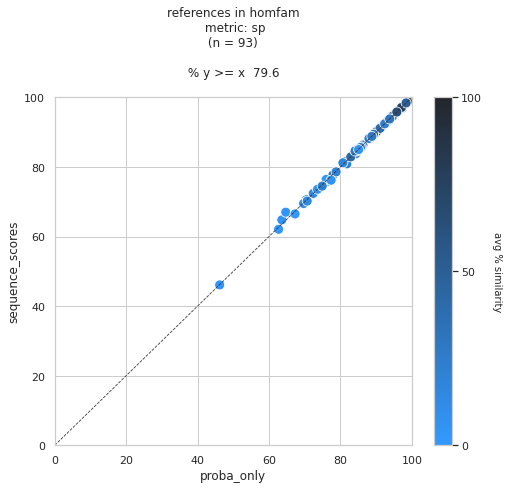

In [8]:
plot_scatter_perc(proba_only, sequence_scores, "proba_only", "sequence_scores", metric = "sp", title = "references in homfam")

/tmp/ipykernel_34172/1031442457.py:68: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar =ax.figure.colorbar(sm, ticks=[0,50,100], format=mpl.ticker.ScalarFormatter())


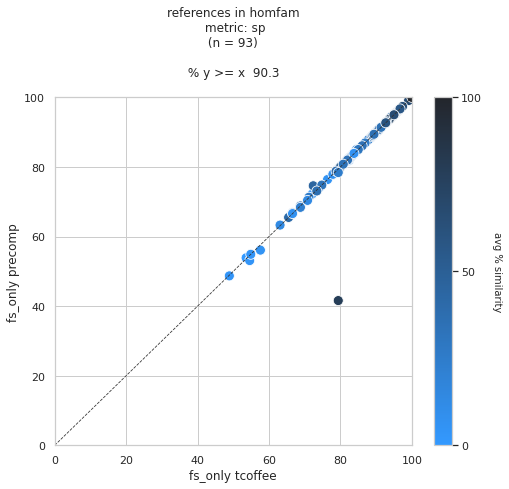

In [9]:
plot_scatter_perc(fs_only, foldseek_scores, "fs_only tcoffee", "fs_only precomp", metric = "sp", title = "references in homfam")

/tmp/ipykernel_34172/1031442457.py:68: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar =ax.figure.colorbar(sm, ticks=[0,50,100], format=mpl.ticker.ScalarFormatter())


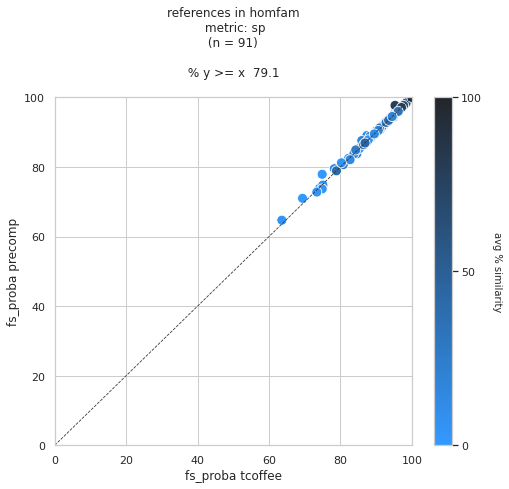

In [10]:
plot_scatter_perc(fs_scores, foldseek_sequence_scores, "fs_proba tcoffee", "fs_proba precomp", metric = "sp", title = "references in homfam")